使用多GPU云服务器

In [1]:
%matplotlib inline 
import torch 
import torchvision
from torch import nn 
from d2l import torch as d2l 

常用的图像增广方法

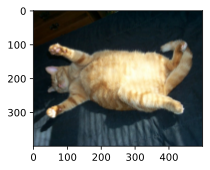

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    """在图片img上多次运行图像增广方法aug并显示所有结果"""
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

翻转和裁剪

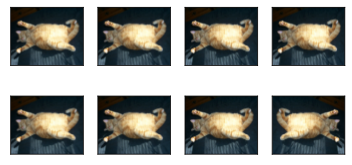

In [4]:
# 随机向左或向右反转图像，概率默认50%
apply(img, torchvision.transforms.RandomHorizontalFlip())

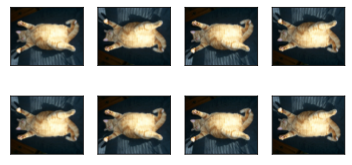

In [5]:
# 随机向上或向下反转图像，概率默认50%
apply(img, torchvision.transforms.RandomVerticalFlip())

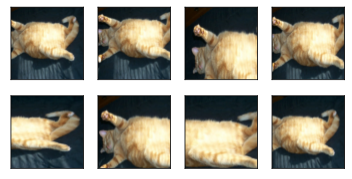

In [6]:
# 区域的宽度和高度均被缩放为200像素，随机裁剪一个面积为原始面积10%~100%的区域，该区域的宽高比在0.5~2随机取值
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

改变颜色

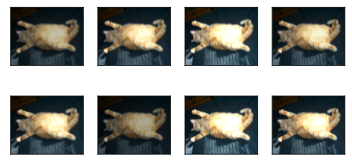

In [7]:
# 亮度、对比度、饱和度、色调
# 随机改变图像的亮度，随机值为原始图像亮度的50%~150%
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

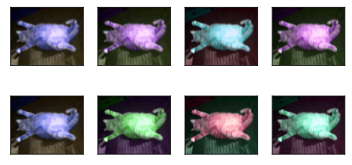

In [8]:
# 随机改变图像的色调，随机值为原始图像色调的50%~150%
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

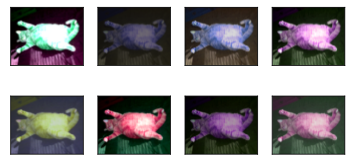

In [9]:
color_aug = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

结合多种图像增广方法

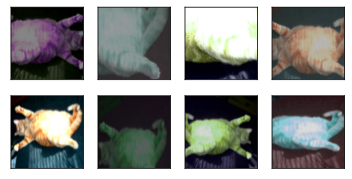

In [10]:
augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

使用图像增广进行训练

Files already downloaded and verified


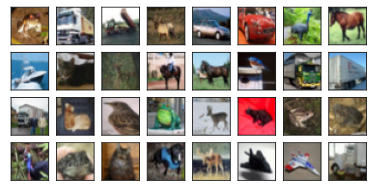

In [11]:
all_images = torchvision.datasets.CIFAR10(root="../data", train=10, download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [12]:
# 只对训练样本进行图像增广，预测中不使用图像增广
train_augs = torchvision.transforms.Compose({
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()})
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train, transform=augs, download=True)
    # num_workers, 默认用4个进程读取数据
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                             shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

多GPU训练

In [14]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [ ]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度: 存储训练损失、训练准确度、实例数、特征数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel()) # numel() 计算元素总数
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches-1: # 每5个批次绘图
                # 训练结果
                # 对准确率，分母是labels.numel(), 这是考虑到多标签分类问题
                animator.add(epoch+(i+1)/num_batches, (metric[0]/metric[2], metric[1]/metric[3], None))
        # 绘制测试结果
        test_acc = d2l.evaluate_accuracy_gpu(net, train_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {metric[0]/metric[2]:.3f}, train acc {metric[1]/metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')


In [16]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    """使用图像增广"""
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.156, train acc 0.946, test acc 0.949
6584.8 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


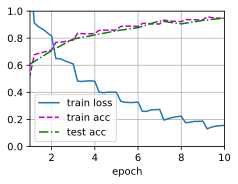

In [19]:
train_with_data_aug(train_augs, test_augs, net)

练习

不使用图像增广的情况下训练模型。

loss 0.080, train acc 0.972, test acc 0.934
6587.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


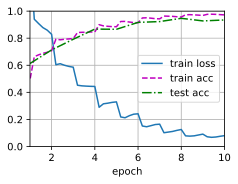

In [21]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(init_weights)
train_with_data_aug(test_augs, test_augs, net)